# Air Quality Prediction Model
This notebook is focused on building a regression model to predict air quality metrics based on historical data.

In [1]:
import time
import warnings
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split

from tqdm import tqdm


from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score
import time
from sklearn.model_selection import KFold

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)

In [2]:
tqdm.pandas()

---

<center><h1>💻💻 Regressor Model 💻 💻</h1></center>

---

In [3]:
# Invoking the prepared data

df = pd.read_csv('working.csv')

In [4]:
df.dtypes

CO(GT)_winsor          float64
PT08.S1(CO)_winsor     float64
PT08.S4(NO2)_winsor    float64
T_winsor               float64
RH_winsor              float64
AH_winsor              float64
day_winsor             float64
year_winsor            float64
quarter_winsor         float64
weekday_winsor         float64
NO2(GT)_winsor         float64
air_quality             object
dtype: object

In [5]:
df.shape

(8421, 12)

## Splitting the set into training and validation sets

In [6]:
train_X = df.drop(['NO2(GT)_winsor', 'air_quality'], axis=1)

In [7]:
train_y = df['NO2(GT)_winsor']

In [8]:
RANDOM_SEED = 16092023

In [9]:
# Let’s split X and y using Train validation split
X_train, X_validation, y_train, y_validation = train_test_split(
    train_X, train_y, train_size=0.8, random_state=RANDOM_SEED, stratify=train_y
)

# get shape of train and test data
print("train data size:", X_train.shape)
print("test data size:", X_validation.shape)

train data size: (6736, 10)
test data size: (1685, 10)


## Regressor Models

The function cv_score_regressor is designed to perform cross-validation for regression models. As is well-known, cross-validation is a technique used to assess the generalization performance of a model on unseen data. This function specifically applies K-Fold cross-validation, which is a commonly used method in machine learning.

In [10]:
def cv_score_regressor(ml_model, rstate=11, cols=None, df=None, df_y=None):
    start_time = time.time()

    if df is None or df_y is None:
        raise ValueError("DataFrames df and df_y must be provided")

    if cols is not None:
        df1 = df[cols].copy()
    else:
        df1 = df.copy()

    cv_scores = []
    
    kf = KFold(n_splits=5, random_state=rstate, shuffle=True)
    
    for train_index, test_index in kf.split(df1):
        xtr, xvl = df1.iloc[train_index], df1.iloc[test_index]
        ytr, yvl = df_y.iloc[train_index], df_y.iloc[test_index]

        model = ml_model
        model.fit(xtr, ytr)
        pred_val = model.predict(xvl)
        
        # Calculate R² score for regression
        score = r2_score(yvl, pred_val)
        
        # Save scores
        cv_scores.append(score)

    end_time = time.time()
    
    print(f"Duration for training the model: {end_time - start_time:.2f} seconds.")
    print(f"Average R² score across folds: {np.mean(cv_scores):.4f}")
    return cv_scores

In [11]:
random_forest_regressor = cv_score_regressor(RandomForestRegressor(n_estimators=100, random_state=20230916), df = X_train, df_y = y_train)

Duration for training the model: 13.10 seconds.
Average R² score across folds: 0.7464


In [12]:
k_neighbors_regressor = cv_score_regressor(KNeighborsRegressor(n_neighbors=3), df = X_train, df_y = y_train)

Duration for training the model: 0.17 seconds.
Average R² score across folds: 0.7136


In [13]:
decision_tree_regressor = cv_score_regressor(DecisionTreeRegressor(random_state=20230916), df = X_train, df_y = y_train)

Duration for training the model: 0.20 seconds.
Average R² score across folds: 0.5195


In [14]:
xgb_regressor = cv_score_regressor(XGBRegressor(random_state=20230916), df = X_train, df_y = y_train)

Duration for training the model: 0.57 seconds.
Average R² score across folds: 0.7248


In [15]:
dictionary_regressor = {
    "RandomForestRegressor": random_forest_regressor,
    "KNeighborsRegressor": k_neighbors_regressor,
    "DecisionTreeRegressor": decision_tree_regressor,
    "XGBRegressor": xgb_regressor,
}

In [16]:
results_df = pd.DataFrame(dictionary_regressor)

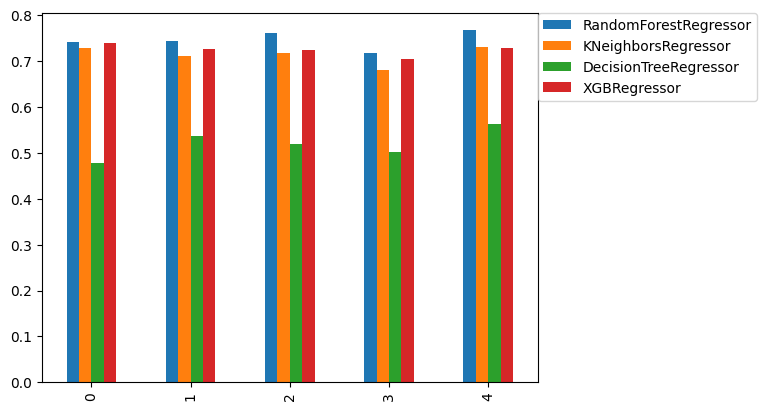

In [17]:
results_df.plot(y=list(dictionary_regressor), kind="bar", legend=False)
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
plt.show()

## Stacking model

We now see the performance of the combination of the models:

In [18]:
# Base models
estimators = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=20230916)),
    ('knr', KNeighborsRegressor(n_neighbors=3)),
    ('dt', DecisionTreeRegressor(random_state=20230916)),
    ('xgb', XGBRegressor(random_state=20230916)),
]

# Meta-model
meta_model = LinearRegression()

# Stacking regressor
stacking_reg = StackingRegressor(estimators=estimators, 
                                 final_estimator=meta_model,
                                 cv=5)

# Fit the model
stacking_reg.fit(X_train, y_train)

# Make predictions
y_pred = stacking_reg.predict(X_validation)

In [19]:
# Function to print model performance metrics
def print_metrics(y_true, y_pred, model_name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    print(f"{model_name} Performance Metrics:")
    print(f"  Mean Absolute Error (MAE): {mae:.4f}")
    print(f"  Mean Squared Error (MSE): {mse:.4f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"  R² Score: {r2:.4f}")
    print("-" * 40)

In [20]:
# Evaluate the stacking regressor
y_pred_stack = stacking_reg.predict(X_validation)
print_metrics(y_validation, y_pred_stack, model_name="Stacking Regressor")

# Evaluate each individual base model
for name, model in estimators:
    model.fit(X_train, y_train)  # Fit the base model on the training data
    y_pred = model.predict(X_validation)  # Predict on the validation data
    print_metrics(y_validation, y_pred, model_name=name)

Stacking Regressor Performance Metrics:
  Mean Absolute Error (MAE): 0.0690
  Mean Squared Error (MSE): 0.0123
  Root Mean Squared Error (RMSE): 0.1109
  R² Score: 0.7527
----------------------------------------
rf Performance Metrics:
  Mean Absolute Error (MAE): 0.0727
  Mean Squared Error (MSE): 0.0131
  Root Mean Squared Error (RMSE): 0.1143
  R² Score: 0.7371
----------------------------------------
knr Performance Metrics:
  Mean Absolute Error (MAE): 0.0722
  Mean Squared Error (MSE): 0.0142
  Root Mean Squared Error (RMSE): 0.1192
  R² Score: 0.7144
----------------------------------------
dt Performance Metrics:
  Mean Absolute Error (MAE): 0.0918
  Mean Squared Error (MSE): 0.0233
  Root Mean Squared Error (RMSE): 0.1526
  R² Score: 0.5317
----------------------------------------
xgb Performance Metrics:
  Mean Absolute Error (MAE): 0.0765
  Mean Squared Error (MSE): 0.0141
  Root Mean Squared Error (RMSE): 0.1189
  R² Score: 0.7159
----------------------------------------


We observe that stacking several models provide a final predictor model. However, one of the limitations of stacking is that it is not possible to verify the feature importances behind the model.

# Hyperparameter Tunning

In [21]:
RANDOM_SEED = 20230916

## RandomForestRegressor

In [22]:
# RandomForestRegressor
rf = RandomForestRegressor(random_state=RANDOM_SEED)
param_grid_forest = {
    "n_estimators": [100, 200, 300],
    "max_depth": [5, 10, 15],
    "max_leaf_nodes": [50, 100],
}

grid_forest = GridSearchCV(
    estimator=rf, param_grid=param_grid_forest, cv=5, n_jobs=-1, scoring="neg_mean_squared_error", verbose=0
)

model_forest = grid_forest.fit(X_train, y_train)

The associated metrics to the model are:

In [23]:
# Extract the best parameters for RandomForestRegressor
best_params_forest = grid_forest.best_params_

# Train the model with the best parameters
best_model_forest = RandomForestRegressor(**best_params_forest, random_state=RANDOM_SEED)
best_model_forest.fit(X_train, y_train)

# Make predictions
y_pred_forest = best_model_forest.predict(X_validation)

# Calculate and print metrics
print("RandomForestRegressor Metrics with Best Params:")
print_metrics(y_validation, y_pred_forest, model_name="RandomForestRegressor")

RandomForestRegressor Metrics with Best Params:
RandomForestRegressor Performance Metrics:
  Mean Absolute Error (MAE): 0.0843
  Mean Squared Error (MSE): 0.0149
  Root Mean Squared Error (RMSE): 0.1222
  R² Score: 0.6996
----------------------------------------


## KNeighborsRegressor

In [24]:
# KNeighborsRegressor
knr = KNeighborsRegressor()
param_grid_knr = {
    "n_neighbors": [3, 5, 7],
    "weights": ["uniform", "distance"],
    "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
}

grid_knr = GridSearchCV(
    estimator=knr, param_grid=param_grid_knr, cv=5, n_jobs=-1, scoring="neg_mean_squared_error", verbose=0
)

model_knr = grid_knr.fit(X_train, y_train)

The associated metrics to the model are:

In [25]:
# Extract the best parameters for KNeighborsRegressor
best_params_knr = grid_knr.best_params_

# Train the model with the best parameters
best_model_knr = KNeighborsRegressor(**best_params_knr)
best_model_knr.fit(X_train, y_train)

# Make predictions
y_pred_knr = best_model_knr.predict(X_validation)

# Calculate and print metrics
print("KNeighborsRegressor Metrics with Best Params:")
print_metrics(y_validation, y_pred_knr, model_name="KNeighborsRegressor")

KNeighborsRegressor Metrics with Best Params:
KNeighborsRegressor Performance Metrics:
  Mean Absolute Error (MAE): 0.0724
  Mean Squared Error (MSE): 0.0136
  Root Mean Squared Error (RMSE): 0.1167
  R² Score: 0.7263
----------------------------------------


## DecisionTreeRegressor

In [26]:
# DecisionTreeRegressor
dt = DecisionTreeRegressor(random_state=RANDOM_SEED)
param_grid_dt = {
    "max_depth": [5, 10, 15],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_leaf_nodes": [50, 100, None],
}

grid_dt = GridSearchCV(
    estimator=dt, param_grid=param_grid_dt, cv=5, n_jobs=-1, scoring="neg_mean_squared_error", verbose=0
)

model_dt = grid_dt.fit(X_train, y_train)

In [27]:
# Extract the best parameters for DecisionTreeRegressor
best_params_dt = grid_dt.best_params_

# Train the model with the best parameters
best_model_dt = DecisionTreeRegressor(**best_params_dt, random_state=RANDOM_SEED)
best_model_dt.fit(X_train, y_train)

# Make predictions
y_pred_dt = best_model_dt.predict(X_validation)

# Calculate and print metrics
print("DecisionTreeRegressor Metrics with Best Params:")
print_metrics(y_validation, y_pred_dt, model_name="DecisionTreeRegressor")

DecisionTreeRegressor Metrics with Best Params:
DecisionTreeRegressor Performance Metrics:
  Mean Absolute Error (MAE): 0.0923
  Mean Squared Error (MSE): 0.0185
  Root Mean Squared Error (RMSE): 0.1358
  R² Score: 0.6289
----------------------------------------


## XGBRegressor

In [28]:
# XGBRegressor
xgb = XGBRegressor(random_state=RANDOM_SEED)
param_grid_xgb = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
}

grid_xgb = GridSearchCV(
    estimator=xgb, param_grid=param_grid_xgb, cv=5, n_jobs=-1, scoring="neg_mean_squared_error", verbose=0
)

model_xgb = grid_xgb.fit(X_train, y_train)

In [29]:
# Extract the best parameters for XGBRegressor
best_params_xgb = grid_xgb.best_params_

# Train the model with the best parameters
best_model_xgb = XGBRegressor(**best_params_xgb, random_state=RANDOM_SEED)
best_model_xgb.fit(X_train, y_train)

# Make predictions
y_pred_xgb = best_model_xgb.predict(X_validation)

# Calculate and print metrics
print("XGBRegressor Metrics with Best Params:")
print_metrics(y_validation, y_pred_xgb, model_name="XGBRegressor")

XGBRegressor Metrics with Best Params:
XGBRegressor Performance Metrics:
  Mean Absolute Error (MAE): 0.0766
  Mean Squared Error (MSE): 0.0129
  Root Mean Squared Error (RMSE): 0.1136
  R² Score: 0.7405
----------------------------------------


## Comparing visually the different models

In [30]:
# Function to calculate metrics and store results
def calculate_and_store_metrics(model_name, y_true, y_pred):
    model_names.append(model_name)
    mae_scores.append(mean_absolute_error(y_true, y_pred))
    mse_scores.append(mean_squared_error(y_true, y_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_true, y_pred)))
    r2_scores.append(r2_score(y_true, y_pred))

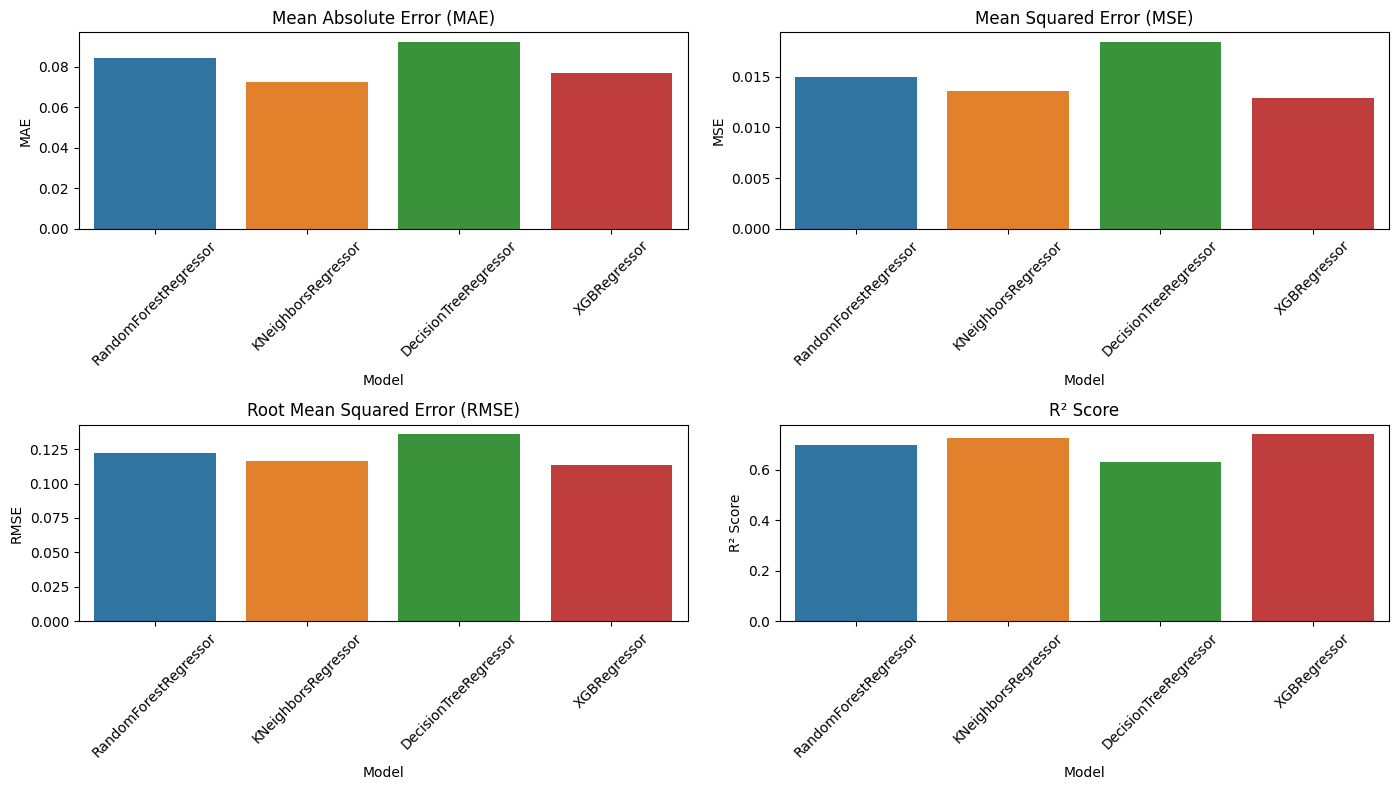

In [31]:
# Initialize lists to store results
model_names = []
mae_scores = []
mse_scores = []
rmse_scores = []
r2_scores = []

# Calculate and store metrics for each model
calculate_and_store_metrics("RandomForestRegressor", y_validation, y_pred_forest)
calculate_and_store_metrics("KNeighborsRegressor", y_validation, y_pred_knr)
calculate_and_store_metrics("DecisionTreeRegressor", y_validation, y_pred_dt)
calculate_and_store_metrics("XGBRegressor", y_validation, y_pred_xgb)

# Create a DataFrame for easier plotting
metrics_df = pd.DataFrame({
    "Model": model_names,
    "MAE": mae_scores,
    "MSE": mse_scores,
    "RMSE": rmse_scores,
    "R² Score": r2_scores
})

# Set up the matplotlib figure
plt.figure(figsize=(14, 8))

# Plot MAE
plt.subplot(2, 2, 1)
sns.barplot(x="Model", y="MAE", data=metrics_df)
plt.title("Mean Absolute Error (MAE)")
plt.xticks(rotation=45)

# Plot MSE
plt.subplot(2, 2, 2)
sns.barplot(x="Model", y="MSE", data=metrics_df)
plt.title("Mean Squared Error (MSE)")
plt.xticks(rotation=45)

# Plot RMSE
plt.subplot(2, 2, 3)
sns.barplot(x="Model", y="RMSE", data=metrics_df)
plt.title("Root Mean Squared Error (RMSE)")
plt.xticks(rotation=45)

# Plot R² Score
plt.subplot(2, 2, 4)
sns.barplot(x="Model", y="R² Score", data=metrics_df)
plt.title("R² Score")
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

We note that in fact, the XGBRegressor model has the best performance.

## Test set performance of the models

For the test set we verify our results in order to avoid overfitting of bad choices of the best models.

In [32]:
# Invoking the prepared data

df_test = pd.read_csv('test.csv')

In [33]:
df_test

,CO(GT)_winsor,PT08.S1(CO)_winsor,PT08.S4(NO2)_winsor,T_winsor,RH_winsor,AH_winsor,day_winsor,year_winsor,quarter_winsor,weekday_winsor,NO2(GT)_winsor,air_quality
0,0.267191,0.144594,0.483118,0.707797,0.935253,0.798549,0.984258,0.0,1.000000,0.805005,0.296865,moderate
1,0.378235,0.007531,0.000000,0.580422,0.076461,0.000000,0.878476,0.0,1.000000,0.950255,0.617513,bad
2,0.467871,0.530776,0.372366,0.606734,0.734302,0.422854,0.832205,1.0,0.000000,0.487394,0.816394,bad
3,0.307132,0.168026,0.351470,0.678158,0.821673,0.618247,0.794773,0.0,1.000000,0.950255,0.446722,moderate
4,0.803512,0.906306,0.555798,0.440792,0.770352,0.295398,0.773401,1.0,0.000000,0.950255,1.000000,bad
...,...,...,...,...,...,...,...,...,...,...,...,...
931,0.643537,0.391196,0.841740,0.972724,0.068836,0.602052,0.621328,0.0,0.496334,0.000000,0.672476,bad
932,0.307132,0.051825,0.000000,0.000000,0.467135,0.000000,0.000000,1.0,0.000000,0.487394,0.686390,bad
933,0.542470,0.144594,0.130666,0.305212,0.723356,0.170278,1.000000,0.0,1.000000,0.887744,0.653240,bad
934,0.542470,0.163040,0.552114,0.947156,0.337640,0.766151,0.992290,0.0,0.793333,1.000000,0.653240,bad


In [34]:
X_test = df_test.drop(['NO2(GT)_winsor', 'air_quality'], axis=1)

In [35]:
y_test = df_test['NO2(GT)_winsor']

In [36]:
# RandomForestRegressor
y_test_pred_forest = best_model_forest.predict(X_test)
print_metrics(y_test, y_test_pred_forest, model_name="RandomForestRegressor")

# KNeighborsRegressor
y_test_pred_knr = best_model_knr.predict(X_test)
print_metrics(y_test, y_test_pred_knr, model_name="KNeighborsRegressor")

# DecisionTreeRegressor
y_test_pred_dt = best_model_dt.predict(X_test)
print_metrics(y_test, y_test_pred_dt, model_name="DecisionTreeRegressor")

# XGBRegressor
y_test_pred_xgb = best_model_xgb.predict(X_test)
print_metrics(y_test, y_test_pred_xgb, model_name="XGBRegressor")

RandomForestRegressor Performance Metrics:
  Mean Absolute Error (MAE): 0.0834
  Mean Squared Error (MSE): 0.0143
  Root Mean Squared Error (RMSE): 0.1194
  R² Score: 0.7173
----------------------------------------
KNeighborsRegressor Performance Metrics:
  Mean Absolute Error (MAE): 0.0723
  Mean Squared Error (MSE): 0.0133
  Root Mean Squared Error (RMSE): 0.1151
  R² Score: 0.7372
----------------------------------------
DecisionTreeRegressor Performance Metrics:
  Mean Absolute Error (MAE): 0.0919
  Mean Squared Error (MSE): 0.0178
  Root Mean Squared Error (RMSE): 0.1333
  R² Score: 0.6478
----------------------------------------
XGBRegressor Performance Metrics:
  Mean Absolute Error (MAE): 0.0776
  Mean Squared Error (MSE): 0.0128
  Root Mean Squared Error (RMSE): 0.1130
  R² Score: 0.7467
----------------------------------------


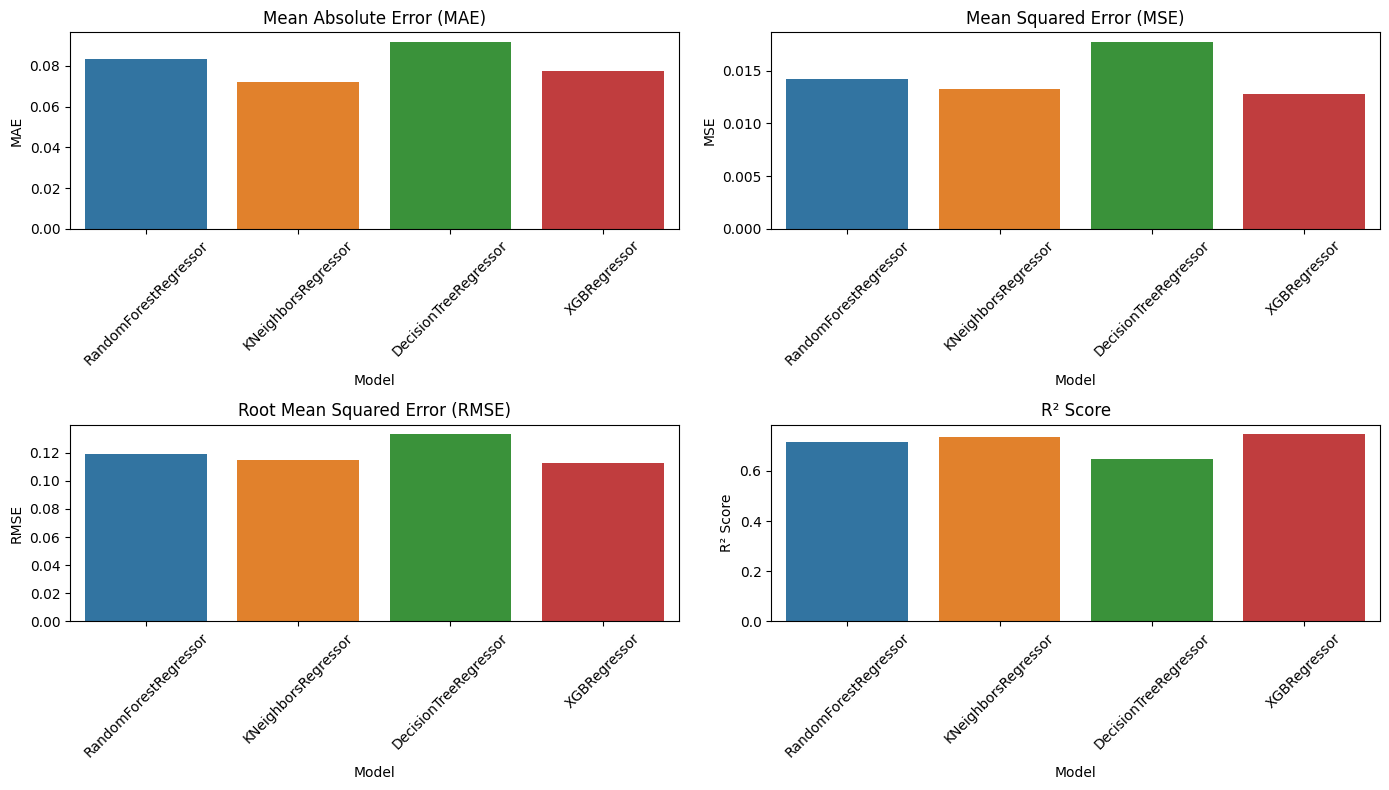

In [45]:
# Initialize lists to store results
model_names = []
mae_scores = []
mse_scores = []
rmse_scores = []
r2_scores = []

# Calculate and store metrics for each model
calculate_and_store_metrics("RandomForestRegressor", y_test, y_test_pred_forest)
calculate_and_store_metrics("KNeighborsRegressor", y_test, y_test_pred_knr)
calculate_and_store_metrics("DecisionTreeRegressor", y_test, y_test_pred_dt)
calculate_and_store_metrics("XGBRegressor", y_test, y_test_pred_xgb)

# Create a DataFrame for easier plotting
metrics_df = pd.DataFrame({
    "Model": model_names,
    "MAE": mae_scores,
    "MSE": mse_scores,
    "RMSE": rmse_scores,
    "R² Score": r2_scores
})

# Set up the matplotlib figure
plt.figure(figsize=(14, 8))

# Plot MAE
plt.subplot(2, 2, 1)
sns.barplot(x="Model", y="MAE", data=metrics_df)
plt.title("Mean Absolute Error (MAE)")
plt.xticks(rotation=45)

# Plot MSE
plt.subplot(2, 2, 2)
sns.barplot(x="Model", y="MSE", data=metrics_df)
plt.title("Mean Squared Error (MSE)")
plt.xticks(rotation=45)

# Plot RMSE
plt.subplot(2, 2, 3)
sns.barplot(x="Model", y="RMSE", data=metrics_df)
plt.title("Root Mean Squared Error (RMSE)")
plt.xticks(rotation=45)

# Plot R² Score
plt.subplot(2, 2, 4)
sns.barplot(x="Model", y="R² Score", data=metrics_df)
plt.title("R² Score")
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

We deduce that, in fact, the `best` model corresponds to the XGBRegressor. 

## Feature importances

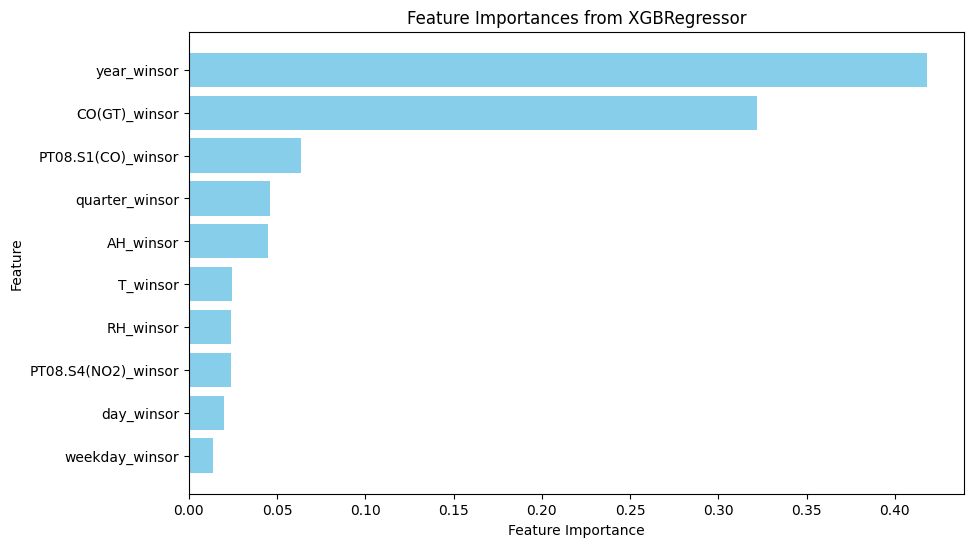

In [46]:
# Extract feature importances
feature_importances = best_model_xgb.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': list(X_train.columns),
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from XGBRegressor')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

## Stacking all the different `best` models

In [47]:
estimators = [
    ('rf', RandomForestRegressor(**best_params_forest, random_state=RANDOM_SEED)),
    ('knr', KNeighborsRegressor(**best_params_knr)),
    ('dt', DecisionTreeRegressor(**best_params_dt, random_state=RANDOM_SEED)),
    ('xgb', XGBRegressor(**best_params_xgb, random_state=RANDOM_SEED)),
]

meta_model = LinearRegression()

stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=meta_model, cv=5)
stacking_regressor.fit(X_train, y_train)

StackingRegressor(cv=5,
                  estimators=[('rf',
                               RandomForestRegressor(max_depth=10,
                                                     max_leaf_nodes=100,
                                                     n_estimators=200,
                                                     random_state=20230916)),
                              ('knr',
                               KNeighborsRegressor(n_neighbors=7,
                                                   weights='distance')),
                              ('dt',
                               DecisionTreeRegressor(max_depth=10,
                                                     max_leaf_nodes=100,
                                                     min_samples_leaf=4,
                                                     min_samples_split=10,
                                                     random_state=20230916)),
                              ('xgb',
                               XGBRegressor(base_sco...
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=5,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=20230916, ...))],
                  final_estimator=LinearRegression())

In [48]:
y_validation_pred_stack = stacking_regressor.predict(X_validation)
y_test_pred_stack = stacking_regressor.predict(X_test)

In [49]:
print_metrics(y_validation, y_validation_pred_stack, model_name="Stacking Regressor")
print_metrics(y_test, y_test_pred_stack, model_name="Stacking Regressor")

Stacking Regressor Performance Metrics:
  Mean Absolute Error (MAE): 0.0712
  Mean Squared Error (MSE): 0.0123
  Root Mean Squared Error (RMSE): 0.1108
  R² Score: 0.7531
----------------------------------------
Stacking Regressor Performance Metrics:
  Mean Absolute Error (MAE): 0.0710
  Mean Squared Error (MSE): 0.0120
  Root Mean Squared Error (RMSE): 0.1093
  R² Score: 0.7630
----------------------------------------


# Limitations of Air Quality Models
## Data Quality and Availability:
1. Incomplete data, for example, respect geolocation or vehicular traffic, or devices errors/calibrations can limit the accuracy of predictions.
2. Lack of real-time data integration might affect the responsiveness of the model to sudden changes in air quality.
3. Models might not adequately represent local variations if the spatial resolution is too coarse.
## Possible Improvements
1. Increase the spatial and temporal resolution of models to capture microclimates and rapid changes better.
2. Use localized models for areas with significant human activity to get more accurate predictions for those regions.
3. Include traffic data, industrial output, and even social media data for real-time incident reporting.
4. Use advanced meteorological modeling to better understand and predict the impact of weather conditions.
5. Develop an integrated system that combines air quality data with public health data to directly correlate pollution levels with health outcomes. Different data sources APIs, etc.
6. Implement real-time data processing and predictive analytics to provide immediate warnings and updates.
7. Leverage IoT and edge computing to process data closer to the source, reducing latency.
# Technical requirements
1. We would require MLOps frameworks to put in production such type of models.
2. It would be important to consider a machine learning architecture to integrate the different data sources with the different stages of the production phase.
3. Continuously monitoring of model performance and data distribution.
4. Real-time or near-to-real-time responses, depending of the final bussiness goal, e.g. reduce the bad quality of air by locations, hours, etc.
5. Track the different models in order to mabage the manage machine learning lifecycle;
6. A/B Testing to verify that different models in fact preserve suitable metrics in real-world scenarios;
7. Integration of different data sources;traffic, industrial outputs, and social media.